# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.




# Criteria

T​his project will be graded based the performance of each part of the pipeline: l​ane instance segmentation (4 points max), homography prediction and image projection (4 points max), and lane fitting (2 points max). The final grade is the sum of grades for each part.



# Solution

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [1]:
!mkdir -p /data/tusimple
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /data/tusimple  #

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /data/tusimple/clips/0313-1/24060/19.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/18.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/17.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/16.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/15.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/14.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/13.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/12.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/11.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/10.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/9.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/8.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/7.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/6.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/5.jpg  
  inflating: /data/tusimple/clips/0313-1/24060/4.jpg  
  inflating: /data/tusimple/clips/0313-1/2

# Part 1. Lane instance segmentation 

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

See also paper:
[Towards End-to-End Lane Detection: an Instance Segmentation Approach](https://www.researchgate.net/figure/LaneNet-architecture-It-consists-of-two-branches-The-segmentation-branch-bottom-is_fig2_323217238)


In [62]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import json
from albumentations import (
    Compose,
    HorizontalFlip,
    OneOf,
    OpticalDistortion,
    RandomBrightnessContrast,
    RandomGamma,
)

DEFAULT_SIZE = (512, 256)


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, size=DEFAULT_SIZE, phase="train", transform=None):
        self.__image_list = []
        self.__lanes_list = []

        self.__dataset_path = dataset_path
        self.__phase = phase
        self.__size = size
        self.__transform = transform

        if self.__phase in ["train", "val"]:
            label_files = list()

            if self.__phase == "train":
                label_files.append(
                    os.path.join(self.__dataset_path, "label_data_0313.json")
                )
                label_files.append(
                    os.path.join(self.__dataset_path, "label_data_0531.json")
                )
            else:
                label_files.append(
                    os.path.join(self.__dataset_path, "label_data_0601.json")
                )

            for file in label_files:
                for line in open(file).readlines():
                    info_dict = json.loads(line)

                    self.__image_list.append(info_dict["raw_file"])

                    h_samples = info_dict["h_samples"]
                    lanes = info_dict["lanes"]
                    xy_list = list()

                    for lane in lanes:
                        y = np.array([h_samples]).T
                        x = np.array([lane]).T
                        xy = np.hstack((x, y))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                    self.__lanes_list.append(xy_list)

    def __getitem__(self, idx):
        # TODO
        if self.__phase in ["train", "val"]:
            img_path = os.path.join(self.__dataset_path, self.__image_list[idx])
            image = cv2.imread(img_path, cv2.IMREAD_COLOR)
            h, w, c = image.shape
            image = cv2.resize(image, self.__size, interpolation=cv2.INTER_LINEAR)

            if self.__phase == "train":
                if self.__transform:
                    img = self.__transform(image)
                else:
                    aug = Compose(
                        [
                            OneOf(
                                [
                                    HorizontalFlip(p=0.5),
                                    RandomBrightnessContrast(
                                        always_apply=False,
                                        p=0.3,
                                        brightness_limit=(-0.2, 0.2),
                                        contrast_limit=(-0.2, 0.2),
                                    ),
                                    RandomGamma(
                                        always_apply=False, p=0.3, gamma_limit=(70, 130)
                                    ),
                                ],
                                p=0.4,
                            ),
                            OneOf(
                                [
                                    OpticalDistortion(
                                        always_apply=False,
                                        p=0.3,
                                        distort_limit=(-0.1, 0.1),
                                        shift_limit=(-0.1, 0.1),
                                        interpolation=0,
                                        border_mode=0
                                    ),
                                ],
                                p=0.3,
                            ),
                        ]
                    )
            else:
                aug = Compose([])

            bin_seg_label = np.zeros((h, w), dtype=np.uint8)
            inst_seg_label = np.zeros((h, w), dtype=np.uint8)
            lanes = self.__lanes_list[idx]

            for idx, lane in enumerate(lanes):
                cv2.polylines(bin_seg_label, [lane], False, 1, 10)
                cv2.polylines(inst_seg_label, [lane], False, idx + 1, 10)

            bin_seg_label = cv2.resize(
                bin_seg_label, self.__size, interpolation=cv2.INTER_NEAREST
            )
            inst_seg_label = cv2.resize(
                inst_seg_label, self.__size, interpolation=cv2.INTER_NEAREST
            )

            bin_seg_label = np.broadcast_to(
                bin_seg_label[..., None], bin_seg_label.shape + (3,)
            )
            inst_seg_label = np.broadcast_to(
                inst_seg_label[..., None], inst_seg_label.shape + (3,)
            )

            augmented = aug(image=image, masks=[bin_seg_label, inst_seg_label])

            image = augmented["image"]
            bin_seg_label = augmented["masks"][0]
            inst_seg_label = augmented["masks"][1]

            image = torch.from_numpy(image).float()
            bin_seg_label = bin_seg_label[:, :, 0]
            inst_seg_label = inst_seg_label[:, :, 0]

            bin_seg_label = torch.from_numpy(bin_seg_label.copy())
            inst_seg_label = torch.from_numpy(inst_seg_label.copy())

            image = np.transpose(image, (2, 0, 1))

            return image, bin_seg_label, inst_seg_label

    def __len__(self):
        # TODO
        return len(self.__image_list)

In [63]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2


class Initial(nn.Module):
    def __init__(self):
        super(Initial, self).__init__()

        self.__net = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(3, 13, 2, stride=2), nn.PReLU(), nn.BatchNorm2d(13)
                ),
                nn.MaxPool2d(2),
            ]
        )

    def forward(self, x):
        y = x
        x = self.__net[0](x)
        y = self.__net[1](y)
        return torch.cat([x, y], dim=1)


class Bottleneck(nn.Module):
    def __init__(
        self,
        in_ch,
        out_ch,
        dropout_prob,
        module_type="downsampling",
        padding=0,
        ratio=2,
    ):
        super(Bottleneck, self).__init__()

        self.__module_type = module_type
        if self.__module_type == "downsampling":
            self.__net = nn.ModuleDict(
                {
                    "block1": nn.Sequential(
                        nn.Conv2d(in_ch, out_ch, 2, stride=2),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "block2": nn.Sequential(
                        nn.Conv2d(out_ch, out_ch, 3, padding=padding),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "block3": nn.Sequential(
                        nn.Conv2d(out_ch, out_ch, 1), nn.PReLU(), nn.BatchNorm2d(out_ch)
                    ),
                    "dropout": nn.Dropout2d(p=dropout_prob),
                    "pooling": nn.MaxPool2d(2),
                    "1*1": nn.Conv2d(in_ch, out_ch, 1),
                }
            )

        elif self.__module_type.split()[0] == "asymmetric":
            self.__net = nn.ModuleDict(
                {
                    "block1": nn.Sequential(
                        nn.Conv2d(in_ch, in_ch // ratio, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block2": nn.Sequential(
                        nn.Sequential(
                            nn.Conv2d(
                                in_ch // ratio, in_ch // ratio, (5, 1), padding=(2, 0)
                            ),
                            nn.Conv2d(
                                in_ch // ratio, in_ch // ratio, (1, 5), padding=(0, 2)
                            ),
                        ),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block3": nn.Sequential(
                        nn.Conv2d(in_ch // ratio, out_ch, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "dropout": nn.Dropout2d(p=dropout_prob),
                }
            )

        elif self.__module_type.split()[0] == "dilated":
            self.__net = nn.ModuleDict(
                {
                    "block1": nn.Sequential(
                        nn.Conv2d(in_ch, in_ch // ratio, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block2": nn.Sequential(
                        nn.Conv2d(
                            in_ch // ratio,
                            in_ch // ratio,
                            3,
                            dilation=int(module_type.split()[1]),
                            padding=padding,
                        ),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block3": nn.Sequential(
                        nn.Conv2d(in_ch // ratio, out_ch, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "dropout": nn.Dropout2d(p=dropout_prob),
                }
            )
        elif self.__module_type == "normal":
            self.__net = nn.ModuleDict(
                {
                    "block1": nn.Sequential(
                        nn.Conv2d(in_ch, in_ch // ratio, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block2": nn.Sequential(
                        nn.Conv2d(in_ch // ratio, in_ch // ratio, 3, padding=padding),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block3": nn.Sequential(
                        nn.Conv2d(in_ch // ratio, out_ch, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "dropout": nn.Dropout2d(p=dropout_prob),
                }
            )
        elif self.__module_type == "upsampling":
            self.__net = nn.ModuleDict(
                {
                    "block1": nn.Sequential(
                        nn.Conv2d(in_ch, in_ch // ratio, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block2": nn.Sequential(
                        nn.ConvTranspose2d(
                            in_ch // ratio, in_ch // ratio, 2, stride=2, padding=padding
                        ),
                        nn.PReLU(),
                        nn.BatchNorm2d(in_ch // ratio),
                    ),
                    "block3": nn.Sequential(
                        nn.Conv2d(in_ch // ratio, out_ch, 1),
                        nn.PReLU(),
                        nn.BatchNorm2d(out_ch),
                    ),
                    "block4": nn.Conv2d(in_ch, out_ch, 1),
                    "dropout": nn.Dropout2d(p=dropout_prob),
                }
            )

    def forward(self, x, prev=None):
        y = x
        if self.__module_type == "downsampling":
            x = self.__net["block1"](x)
            x = self.__net["block2"](x)
            x = self.__net["block3"](x)
            x = self.__net["dropout"](x)
            y = self.__net["pooling"](y)
            y = self.__net["1*1"](y)

            return x + y
        else:
            x = self.__net["block1"](x)
            x = self.__net["block2"](x)
            x = self.__net["block3"](x)
            x = self.__net["dropout"](x)
            if self.__module_type == "upsampling":
                return x + prev
            return x + y


class RepeatBlock(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super(RepeatBlock, self).__init__()

        self.add_module(
            "Bottleneck_1",
            Bottleneck(in_ch, out_ch, 0.1, module_type="normal", padding=1),
        )
        self.add_module(
            "Bottleneck_2",
            Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 2", padding=2),
        )
        self.add_module(
            "Bottleneck_3", Bottleneck(out_ch, out_ch, 0.1, module_type="asymmetric")
        )
        self.add_module(
            "Bottleneck_4",
            Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 4", padding=4),
        )
        self.add_module(
            "Bottleneck_5",
            Bottleneck(out_ch, out_ch, 0.1, module_type="normal", padding=1),
        )
        self.add_module(
            "Bottleneck_6",
            Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 8", padding=8),
        )
        self.add_module(
            "Bottleneck_7", Bottleneck(out_ch, out_ch, 0.1, module_type="asymmetric")
        )
        self.add_module(
            "Bottleneck_8",
            Bottleneck(out_ch, out_ch, 0.1, module_type="dilated 16", padding=16),
        )


class SharedEncoder(nn.Module):
    def __init__(self):
        super(SharedEncoder, self).__init__()

        self.__initial = Initial()
        self.__downsample = nn.ModuleDict(
            {
                "downsample_1": Bottleneck(16, 64, 0.01, padding=1),
                "downsample_2": Bottleneck(64, 128, 0.1, padding=1),
            }
        )
        self.__net = nn.Sequential(
            Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
            Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
            Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
            Bottleneck(64, 64, 0.01, module_type="normal", padding=1),
        )
        self.__tail = RepeatBlock(128, 128)

    def forward(self, x):
        prevs = []
        x = self.__initial(x)
        prevs.append(x)
        x = self.__downsample["downsample_1"](x)
        prevs.append(x)
        x = self.__net(x)
        x = self.__downsample["downsample_2"](x)
        x = self.__tail(x)
        return x, prevs


class Decoder(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, final_ch):
        super(Decoder, self).__init__()

        self.__upsample = nn.ModuleDict(
            {
                "upsample_1": Bottleneck(in_ch, mid_ch, 0.1, module_type="upsampling"),
                "upsample_2": Bottleneck(mid_ch, out_ch, 0.1, module_type="upsampling"),
            }
        )
        self.__net = nn.ModuleDict(
            {
                "normal_1": Bottleneck(
                    mid_ch, mid_ch, 0.1, module_type="normal", padding=1
                ),
                "normal_2": Bottleneck(
                    mid_ch, mid_ch, 0.1, module_type="normal", padding=1
                ),
            }
        )
        self.__end = nn.Sequential(nn.ConvTranspose2d(out_ch, final_ch, 2, stride=2))

    def forward(self, x, y):
        x = self.__upsample["upsample_1"](x, y[1])
        x = self.__net["normal_1"](x)
        x = self.__net["normal_2"](x)
        x = self.__upsample["upsample_2"](x, y[0])
        x = self.__end(x)
        return x


class Embedding(nn.Module):
    def __init__(self, emb_size):
        super(Embedding, self).__init__()

        self.__net = nn.ModuleDict(
            {
                "repeat": RepeatBlock(128, 128),
                "decoder": Decoder(128, 64, 16, emb_size),
            }
        )

    def forward(self, x, prevs):
        x = self.__net["repeat"](x)
        x = self.__net["decoder"](x, prevs)
        return x


class Segmentation(nn.Module):
    def __init__(self):
        super(Segmentation, self).__init__()

        self.__net = nn.ModuleDict(
            {"repeat": RepeatBlock(128, 128), "decoder": Decoder(128, 64, 16, 2)}
        )

    def forward(self, x, prevs):
        x = self.__net["repeat"](x)
        x = self.__net["decoder"](x, prevs)
        return x


class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()

        self.__net = nn.ModuleDict(
            {
                "Shared_Encoder": SharedEncoder(),
                "Embedding": Embedding(5),
                "Segmentation": Segmentation(),
            }
        )

    def forward(self, x):
        x, prevs = self.__net["Shared_Encoder"](x)
        embeddings = self.__net["Embedding"](x, prevs)
        segmentation = self.__net["Segmentation"](x, prevs)

        return segmentation, embeddings

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [64]:
import torch
import numpy as np
import os
from collections import defaultdict
import torch.nn as nn
import cv2

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Losses:
    def __init__(
        self,
        batch,
        predictions,
        seg_mask,
        embeddings,
        instance_mask,
        delta_v=0.5,
        delta_d=3,
        alpha=1,
        beta=1,
        gamma=0.001,
    ):

        self.__batch = batch
        self.__predictions = predictions
        self.__seg_mask = seg_mask
        self.__embeddings = embeddings
        self.__instance_mask = instance_mask
        self.__delta_v = delta_v
        self.__delta_d = delta_d
        self.__alpha = alpha
        self.__beta = beta
        self.__gamma = gamma

    def __bi_weight(self):
        frequency = defaultdict(lambda: torch.tensor(0.0).to(DEVICE))
        for i in range(self.__batch):
            img_tensor = self.__seg_mask[i, :, :]
            frequency["background"] += (img_tensor == 0.0).sum()
            frequency["lane"] += (img_tensor == 1.0).sum()
        class_weights = defaultdict(lambda: torch.tensor(0.0))
        class_weights["background"] = 1.0 / torch.log(
            1.02
            + frequency["background"] / (frequency["background"] + frequency["lane"])
        )
        class_weights["lane"] = 1.0 / torch.log(
            1.02 + frequency["lane"] / (frequency["background"] + frequency["lane"])
        )

        return class_weights

    def __segmentation_loss(self):
        class_weights = self.__bi_weight()
        loss = nn.CrossEntropyLoss(
            weight=torch.tensor(
                [class_weights["background"].item(), class_weights["lane"].item()]
            )
        ).to(DEVICE)
        label = self.__seg_mask.type(torch.long)
        loss = loss(self.__predictions, label)

        return loss

    def __discriminative_loss(self):
        num_samples = self.__instance_mask.size(0)

        dis_loss = torch.tensor(0.0).to(DEVICE)
        var_loss = torch.tensor(0.0).to(DEVICE)
        reg_loss = torch.tensor(0.0).to(DEVICE)
        for i in range(num_samples):
            clusters = []
            sample_embedding = self.__embeddings[i, :, :, :]
            sample_label = self.__instance_mask[i, :, :]
            num_clusters = len(sample_label.unique()) - 1
            vals = sample_label.unique()[1:]
            sample_label = sample_label.view(
                sample_label.size(0) * sample_label.size(1)
            )
            sample_embedding = sample_embedding.view(
                -1, sample_embedding.size(1) * sample_embedding.size(2)
            )
            v_loss = torch.tensor(0.0).to(DEVICE)
            d_loss = torch.tensor(0.0).to(DEVICE)
            r_loss = torch.tensor(0.0).to(DEVICE)
            for j in range(num_clusters):
                indices = (sample_label == vals[j]).nonzero()
                indices = indices.squeeze()
                cluster_elements = torch.index_select(sample_embedding, 1, indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cluster)
                v_loss += (
                    torch.pow(
                        (
                            torch.clamp(
                                torch.norm(cluster_elements - mean_cluster)
                                - self.__delta_v,
                                min=0.0,
                            )
                        ),
                        2,
                    ).sum()
                    / Nc
                )
                r_loss += torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx, cluster in enumerate(clusters):
                    if index == idx:
                        continue
                    else:
                        distance = torch.norm(clusters[index] - cluster)
                        d_loss += torch.pow(
                            torch.clamp(self.__delta_d - distance, min=0.0), 2
                        )
            var_loss += v_loss / num_clusters
            dis_loss += d_loss / (num_clusters * (num_clusters - 1))
            reg_loss += r_loss / num_clusters
        return (
            self.__alpha * (var_loss / num_samples)
            + self.__beta * (dis_loss / num_samples)
            + self.__gamma * (reg_loss / num_samples)
        )

    def __total_loss(self):
        segmentation_loss = self.__segmentation_loss()
        discriminative_loss = self.__discriminative_loss()
        total_loss = segmentation_loss + discriminative_loss

        metrics = defaultdict(float)

        metrics["segm"] += segmentation_loss * self.__seg_mask.size(0)
        metrics["discr"] += discriminative_loss * self.__seg_mask.size(0)
        metrics["tot"] += total_loss * self.__seg_mask.size(0)

        return total_loss, segmentation_loss, discriminative_loss, metrics

    def __call__(self):
        return self.__total_loss()

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [65]:
dataset_path = "/data/tusimple"
train_set = LaneDataset(dataset_path, phase="train")
val_set = LaneDataset(dataset_path, phase="val")

batch_size = 8

In [68]:
import matplotlib.pyplot as plt


def build_sampler(train_set, val_set, batch_size):
    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
    )
    val_loader = DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True
    )

    return {"train": train_loader, "val": val_loader}


def plot_images(images, ncol=4):
    nrow = len(images) // ncol

    f, plots = plt.subplots(
        nrow, ncol, sharex="all", sharey="all", figsize=(ncol * 4, nrow * 4)
    )
    for i in range(len(images)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(images[i])

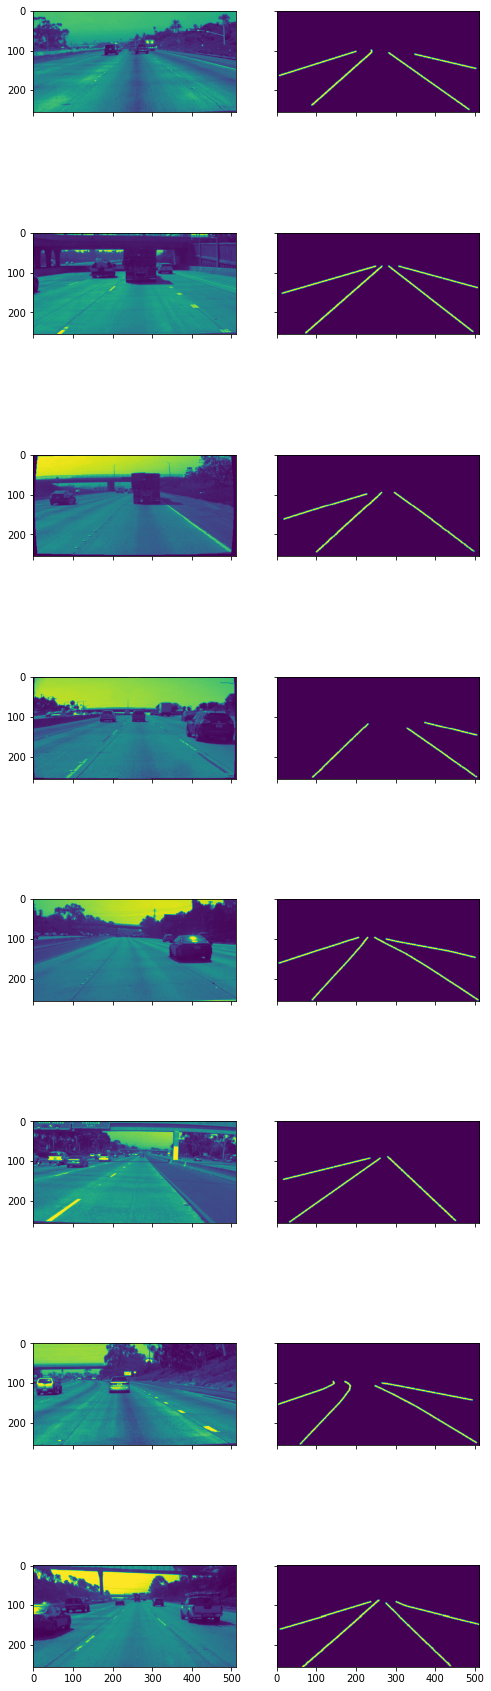

In [69]:
from functools import reduce

dataloaders = build_sampler(train_set, val_set, batch_size)

image, mask, ins_mask = next(iter(dataloaders["train"]))

images = image[:, 0, :, :]
masks = mask[:, :, :]

input_images_rgb = [x for x in images]
target_masks_rgb = [x for x in masks]

img_arrays = [input_images_rgb, target_masks_rgb]

flatten_list = reduce(lambda x, y: x + y, zip(*img_arrays))
plot_images(flatten_list, ncol=len(img_arrays))

In [71]:
from copy import deepcopy
from torch.nn.utils import clip_grad_value_


class Train:
    def __init__(
        self,
        model,
        loss_params,
        dataloader,
        loss=Losses,
        epoch=3,
        batch_size=8,
        lr=5e-4,
    ):
        self.__model = model
        self.__data = dataloader
        self.__epoch = epoch
        self.__batch_size = batch_size
        self.__loss = loss
        self.__loss_params = loss_params
        self.__lr = lr

    def __train(self):
        self.__model = self.__model.to(DEVICE)
        self.__model = self.__model.train()
        params = self.__model.parameters()
        optimizer = torch.optim.Adam(params, lr=self.__lr)

        step = 0
        best_model_wts = deepcopy(self.__model.state_dict())
        best_loss = 999

        for ep in range(self.__epoch):
            print("Epoch {}/{}:".format(ep, self.__epoch))

            for phase in ["train", "val"]:
                if phase == "train":
                    self.__model.train()
                else:
                    self.__model.eval()

                epoch_samples = 0

                for input_data, seg_mask, instance_mask in self.__data[phase]:
                    input_data = input_data.to(DEVICE)
                    seg_mask = seg_mask.to(DEVICE)
                    instance_mask = instance_mask.to(DEVICE)

                    with torch.set_grad_enabled(phase == "train"):
                        predictions, embeddings = self.__model(input_data)
                        total_loss = self.__loss(
                            self.__batch_size,
                            predictions,
                            seg_mask,
                            embeddings,
                            instance_mask,
                            **self.__loss_params
                        )
                        (
                            total_loss,
                            segmentation_loss,
                            discriminative_loss,
                            metrics,
                        ) = total_loss()

                        if phase == "train":
                            optimizer.zero_grad()
                            total_loss.backward()
                            clip_grad_value_(params, clip_value=5.0)
                            optimizer.step()

                    epoch_samples += input_data.size(0)

                computed_metrics = compute_metrics(metrics, epoch_samples)
                print_metrics(computed_metrics, phase)
                epoch_loss = metrics["tot"] / epoch_samples

                if phase == "val" and epoch_loss < best_loss:
                    print(
                        "\tSaving best model, epoch loss {:4f} < best loss {:4f}".format(
                            epoch_loss, best_loss
                        )
                    )
                    best_loss = epoch_loss
                    best_model_wts = deepcopy(self.__model.state_dict())
                    torch.save(
                        self.__model.state_dict(),
                        os.path.join(
                            "/content/drive/MyDrive/CV_SGA/",
                            "enet-{}-{}.pkl".format(best_loss, ep),
                        ),
                    )

        self.__model.load_state_dict(best_model_wts)

    def __call__(self):
        self.__train()


def compute_metrics(metrics, epoch_samples):
    computed_metrics = {}
    for k in metrics.keys():
        computed_metrics[k] = metrics[k] / epoch_samples
    return computed_metrics


def print_metrics(computed_metrics, phase):
    outputs = []
    for k in computed_metrics.keys():
        outputs.append("{}:{:4f}".format(k, computed_metrics[k]))
    print("\t{}-> {}".format(phase.ljust(5), "|".join(outputs)))

In [75]:
# TODO: Train segmentation and instance segmentation
batch_size = 8
num_epoch = 20
learning_rate = 0.001

model = ENet()
loss_parameters = {"delta_v": 0.5, "delta_d": 3, "alpha": 1, "beta": 1, "gamma": 0.001}
data = build_sampler(train_set=train_set, val_set=val_set, batch_size=batch_size)

train = Train(
    model=model,
    loss_params=loss_parameters,
    dataloader=data,
    loss=Losses,
    epoch=num_epoch,
    batch_size=batch_size,
    lr=learning_rate,
)

train()

Epoch 0/20:
	train-> segm:0.000420|discr:0.031412|tot:0.031833
	val  -> segm:0.006299|discr:0.345832|tot:0.352130
	Saving best model, epoch loss 0.352130 < best loss 999.000000
Epoch 1/20:
	train-> segm:0.000515|discr:0.015210|tot:0.015724
	val  -> segm:0.004815|discr:0.136047|tot:0.140862
	Saving best model, epoch loss 0.140862 < best loss 0.352130
Epoch 2/20:
	train-> segm:0.000401|discr:0.007505|tot:0.007906
	val  -> segm:0.004474|discr:0.081868|tot:0.086342
	Saving best model, epoch loss 0.086342 < best loss 0.140862
Epoch 3/20:
	train-> segm:0.000360|discr:0.005577|tot:0.005937
	val  -> segm:0.004317|discr:0.051130|tot:0.055447
	Saving best model, epoch loss 0.055447 < best loss 0.086342
Epoch 4/20:
	train-> segm:0.000327|discr:0.004747|tot:0.005074
	val  -> segm:0.003929|discr:0.037998|tot:0.041927
	Saving best model, epoch loss 0.041927 < best loss 0.055447
Epoch 5/20:
	train-> segm:0.000353|discr:0.003272|tot:0.003625
	val  -> segm:0.004042|discr:0.039285|tot:0.043327
Epoch 6/2

In [76]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 2. Homography prediction and image projection 

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [77]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import json
import numpy as np
import cv2


HNET_DEFAULT_SIZE = (128, 64)


class HomographyPredictionDataset(Dataset):
    def __init__(self, dataset_path, size=HNET_DEFAULT_SIZE, transform=None):
        # TODO
        self.__labels = dict()

        self.__dataset_path = dataset_path
        self.__line_size = 30
        self.__size = size
        self.__transform = transform

        sub_paths = [i for i in os.listdir(self.__dataset_path) if i != ".DS_Store"]
        labels = [self.__dataset_path + "/" + i for i in sub_paths if i[-4:] == "json"]
        images_root_path = self.__dataset_path + "/clips"
        images = list()
        images_folders = [
            self.__dataset_path + "/clips/" + i
            for i in os.listdir(images_root_path)
            if i != ".DS_Store"
        ]

        for imgs_folder in images_folders:
            for i in os.listdir(imgs_folder):
                if "DS" in i:
                    continue

                tmp_path = imgs_folder + "/" + i
                lst_of_imgs = [
                    imgs_folder + "/" + i + "/" + j
                    for j in os.listdir(tmp_path)
                    if j == "20.jpg"
                ]
                images += lst_of_imgs

        self.__images = images
        for label_path in labels:
            with open(label_path, "r") as f:
                for i in f.readlines():
                    todict = json.loads(i[:-1])
                    label_img_name = todict["raw_file"]
                    self.__labels[label_img_name] = todict

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, idx):
        image_path = self.__images[idx]
        key_ind = image_path.split("/").index("clips")
        key_path = os.path.join(*image_path.split("/")[key_ind:])
        abs_path = (
            self.__dataset_path + "/" + os.path.join(*image_path.split("/")[key_ind:])
        )

        label = self.__labels[key_path]
        lanes_w = np.array(label["lanes"])
        lanes_h = np.array(label["h_samples"])
        lane_cnt = lanes_w.shape[0]

        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        x_rescale, y_rescale = (
            image.shape[1] / self.__size[0],
            image.shape[0] / self.__size[1],
        )
        image = cv2.resize(image, dsize=self.__size, interpolation=cv2.INTER_AREA)
        image = np.asarray(image).astype(np.float32)
        image = np.transpose(image, (2, 0, 1))
        image *= 1.0 / image.max()
        lane_pair = list()
        point = 0

        xs = (lanes_w[0, :] - 8) / x_rescale
        if xs.shape[0] == 48:
            for k in range(8):
                xs = np.append(xs, [0])
        ys = lanes_h / y_rescale
        ys = np.clip(ys, 0, 127)
        if ys.shape[0] == 48:
            for k in range(8):
                ys = np.append(ys, [0])
        pair = np.stack([xs, ys])
        lane_pair.append(pair)

        xs = (lanes_w[lane_cnt - 1, :] - 8) / 10
        if xs.shape[0] == 48:
            for k in range(8):
                xs = np.append(xs, [0])
        ys = lanes_h / 11.25
        ys = np.clip(ys, 0, 127)
        if ys.shape[0] == 48:
            for k in range(8):
                ys = np.append(ys, [0])
        pair = np.stack([xs, ys])
        lane_pair.append(pair)

        return np.array(image), np.array(lane_pair).astype(np.float32)

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [78]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [79]:
!wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

--2022-03-20 23:50:49--  https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg
Resolving miro.medium.com (miro.medium.com)... 162.159.153.4, 162.159.152.4, 2606:4700:7::a29f:9904, ...
Connecting to miro.medium.com (miro.medium.com)|162.159.153.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136321 (133K) [image/jpeg]
Saving to: ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’

1*b3HiwPg69Rw0L5iIM 100%[===================>] 133.13K  --.-KB/s    in 0.01s   

2022-03-20 23:50:49 (8.86 MB/s) - ‘1*b3HiwPg69Rw0L5iIMQMXOw.jpeg’ saved [136321/136321]



In [80]:
from matplotlib import pyplot as plt
import cv2

In [81]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [82]:
image = cv2.resize(image, (128, 64))

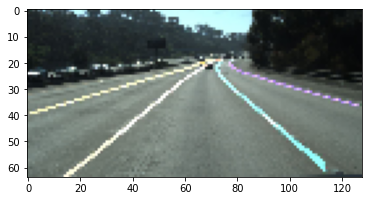

In [83]:
plt.imshow(image)

In [84]:
R_np = R.numpy()

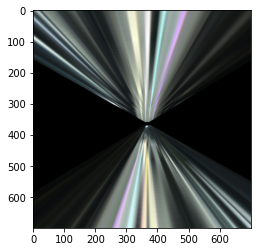

In [85]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [86]:
import torch
import torch.nn as nn

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()

        self.__conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.__bn1 = nn.BatchNorm2d(16)

        self.__conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.__bn2 = nn.BatchNorm2d(16)

        self.__conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.__bn3 = nn.BatchNorm2d(32)

        self.__conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.__bn4 = nn.BatchNorm2d(32)

        self.__conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.__bn5 = nn.BatchNorm2d(64)

        self.__conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.__bn6 = nn.BatchNorm2d(64)

        self.__ln1 = nn.Linear(8192, 1024)
        self.__bn7 = nn.BatchNorm1d(1024)

        self.__ln2 = nn.Linear(1024, 6)

        self.__relu = nn.ReLU(inplace=True)
        self.__maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        x = self.__conv1(x)
        x = self.__relu(self.__bn1(x))
        x = self.__conv2(x)
        x = self.__relu(self.__bn2(x))
        x = self.__maxpool(x)

        x = self.__conv3(x)
        x = self.__relu(self.__bn3(x))
        x = self.__conv4(x)
        x = self.__relu(self.__bn4(x))
        x = self.__maxpool(x)

        x = self.__conv5(x)
        x = self.__relu(self.__bn5(x))
        x = self.__conv6(x)
        x = self.__relu(self.__bn6(x))
        x = self.__maxpool(x)

        x = x.view(x.size(0), -1)
        x = self.__relu(self.__bn7((self.__ln1(x))))
        x = self.__ln2(x)

        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class HomographyLoss(object):
    def __hnet_loss_single(self, pts_gt, trans_coef):
        pts_gt = pts_gt.to(DEVICE)
        trans_coef = trans_coef.to(DEVICE)
        pts_gt = pts_gt.view(-1, 3)
        trans_coef = trans_coef.view(6)

        mult = (
            torch.tensor([1e-02, 1e-01, 1e-01, 1e-01, 1e-01, 1e-03])
            .type(torch.float32)
            .to(DEVICE)
        )
        trans_coef = trans_coef * mult
        trans_coef = torch.cat(
            [trans_coef, torch.tensor([1.0]).type(torch.FloatTensor).to(DEVICE)]
        )

        R = (
            torch.tensor(
                [
                    -2.0484e-01,
                    -1.7122e01,
                    3.7991e02,
                    -1.6969e01,
                    3.7068e02,
                    -4.6739e-01,
                    0.0000e00,
                ]
            )
            .type(torch.FloatTensor)
            .to(DEVICE)
        )

        H_indices = torch.tensor(
            [[0], [1], [2], [4], [5], [7], [8]], requires_grad=False
        ).to(DEVICE)
        H = torch.zeros(9, dtype=torch.float32).to(DEVICE)
        H[H_indices[:, 0]] = R + trans_coef
        H = torch.reshape(H, shape=[3, 3])

        pts_gt = pts_gt[pts_gt[:, 2] == 1]
        pts_gt = pts_gt.view(-1, 3).to(torch.float32).t()

        pts_projected = torch.mm(H, pts_gt)
        if pts_gt.shape[1] < 3:
            return 1.0

        pts_projected = torch.div(pts_projected, pts_projected[2, :])

        X = pts_projected[0, :].view(-1, 1)
        Y = pts_projected[1, :].view(-1, 1)

        Y_mat = torch.cat(
            [torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32)], dim=1
        )

        w = torch.matmul(
            torch.matmul(torch.pinverse(torch.matmul(Y_mat.T, Y_mat)), Y_mat.T), X
        )

        x_pred = torch.mm(Y_mat, w)
        pts_pred = torch.cat(
            [x_pred, Y, torch.ones_like(Y, dtype=torch.float32)], dim=1
        ).t()

        pts_back = torch.mm(H.pinverse(), pts_pred)
        pts_back = torch.div(pts_back, pts_back[2, :])

        loss = torch.mean(torch.pow(pts_gt[0, :] - pts_back[0, :], 2))

        return loss

    def hnet_loss(self, pts_batch, coef_batch):
        pts_batch = pts_batch.to(DEVICE)
        coef_batch = coef_batch.to(DEVICE)

        batch_size = coef_batch.size()[0]

        loss_acc = torch.zeros(batch_size, dtype=torch.float64)

        for i in range(batch_size):
            pts_size = pts_batch.size()[1]
            loss_line = torch.zeros(pts_size, dtype=torch.float64)

            for k, line in enumerate(pts_batch[i]):
                line = line.T
                line = line[line[:, 0] > 0]
                line = torch.cat((line, torch.ones(line.size(0), 1).to(DEVICE)), 1)
                loss_one_line = self.__hnet_loss_single(line, coef_batch[i])
                loss_line[k] = loss_one_line

            loss_acc[i] = loss_line.mean()

        loss = loss_acc.mean()

        return loss

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [88]:
dataset = HomographyPredictionDataset("/data/tusimple")
train_set, val_set = torch.utils.data.random_split(dataset, [3216, 410])
random_sample = dataset[random.randint(0, len(train_set) - 1)]

In [89]:
image = random_sample[0][0]
lane_pair = random_sample[1]
lane_cnt = len(lane_pair)

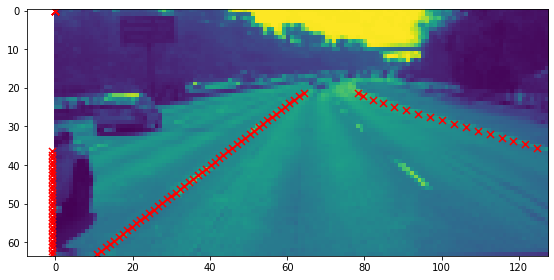

In [91]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(image)
for i in range(lane_cnt):
    plt.scatter(lane_pair[i][0, :], lane_pair[i][1, :], marker="x", s=50, color="red")
plt.show()

In [92]:
batch_size = 6
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True
)

In [93]:
import torch.optim as optim
from tqdm import tqdm

model = HNet()
model = model.to(DEVICE)

epoch = 30
optimizer = optim.SGD(model.parameters(), lr=5e-4)

for ep in range(epoch):
    bgloss = []

    model.train()
    for img, label in tqdm(train_loader):
        img = torch.FloatTensor(img).to(DEVICE)

        gt_labels = torch.FloatTensor(label).to(DEVICE)
        out = model(img)

        loss_fn = HomographyLoss()
        loss = loss_fn.hnet_loss(gt_labels, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bgloss.append(loss.cpu().detach().numpy())
        mn_loss = np.mean(bgloss)

    model.eval()
    with torch.no_grad():
        val_loss = []
        for img, label in tqdm(val_loader):
            img = torch.FloatTensor(img).to(DEVICE)

            gt_labels = torch.FloatTensor(label).to(DEVICE)
            out = model(img)

            loss_fn = HomographyLoss()
            loss = loss_fn.hnet_loss(gt_labels, out)
            val_loss.append(loss.cpu().detach().numpy())

            val_mn_loss = np.mean(val_loss)

    print("Epoch", ep, "Train_Loss", mn_loss, "Val Loss", val_mn_loss)
    torch.save(
        model.state_dict(),
        os.path.join(
            "/content/drive/MyDrive/CV_SGA",
            "hnet-{:.5f}-{}.pkl".format(val_mn_loss, ep)
        )
    )

100%|██████████| 68/68 [00:05<00:00, 13.58it/s]


Epoch 0 Train_Loss 1.0025597995257844 Val Loss 0.258093795385031


100%|██████████| 68/68 [00:05<00:00, 13.01it/s]


Epoch 1 Train_Loss 0.31629053109736593 Val Loss 0.25710033417459915


100%|██████████| 68/68 [00:04<00:00, 13.63it/s]


Epoch 2 Train_Loss 0.2838923078667561 Val Loss 0.2572071253726794


100%|██████████| 68/68 [00:05<00:00, 13.58it/s]


Epoch 3 Train_Loss 0.3562881540325349 Val Loss 0.25649036225140076


100%|██████████| 68/68 [00:04<00:00, 13.92it/s]


Epoch 4 Train_Loss 0.4272202636575639 Val Loss 0.2569613161141393


100%|██████████| 68/68 [00:04<00:00, 13.83it/s]


Epoch 5 Train_Loss 0.3463486853903945 Val Loss 0.26198079163478777


100%|██████████| 68/68 [00:04<00:00, 13.76it/s]


Epoch 6 Train_Loss 0.2804688131319389 Val Loss 0.25559826435535593


100%|██████████| 68/68 [00:04<00:00, 13.81it/s]


Epoch 7 Train_Loss 0.2730583452221404 Val Loss 0.2587278938053803


100%|██████████| 68/68 [00:04<00:00, 13.68it/s]


Epoch 8 Train_Loss 0.3012758969215826 Val Loss 0.2575018279366308


100%|██████████| 68/68 [00:04<00:00, 13.75it/s]


Epoch 9 Train_Loss 0.27806732851477256 Val Loss 0.26346526655880065


100%|██████████| 68/68 [00:04<00:00, 13.94it/s]


Epoch 10 Train_Loss 0.2721421490487663 Val Loss 0.25711924881649206


100%|██████████| 68/68 [00:05<00:00, 13.54it/s]


Epoch 11 Train_Loss 0.26924058204054535 Val Loss 0.26011919414512946


100%|██████████| 68/68 [00:04<00:00, 13.63it/s]


Epoch 12 Train_Loss 0.27095192086583425 Val Loss 0.2578906140579496


100%|██████████| 68/68 [00:04<00:00, 13.95it/s]


Epoch 13 Train_Loss 0.26814383579231515 Val Loss 0.257940604081551


100%|██████████| 68/68 [00:04<00:00, 13.88it/s]


Epoch 14 Train_Loss 0.26974404846253464 Val Loss 0.25508638447500664


100%|██████████| 68/68 [00:04<00:00, 14.00it/s]


Epoch 15 Train_Loss 0.2741223965957724 Val Loss 0.2582686369130208


100%|██████████| 68/68 [00:04<00:00, 13.81it/s]


Epoch 16 Train_Loss 0.2943772041991347 Val Loss 0.25520723151673697


100%|██████████| 68/68 [00:04<00:00, 13.77it/s]


Epoch 17 Train_Loss 0.2719101631295204 Val Loss 0.25661880426321476


100%|██████████| 68/68 [00:04<00:00, 13.86it/s]


Epoch 18 Train_Loss 0.27690718427345395 Val Loss 0.25632527735399774


100%|██████████| 68/68 [00:04<00:00, 14.00it/s]


Epoch 19 Train_Loss 0.26598603899575646 Val Loss 0.2562002096463299


100%|██████████| 68/68 [00:04<00:00, 13.84it/s]


Epoch 20 Train_Loss 0.27190020860208014 Val Loss 0.25629150149624425


100%|██████████| 68/68 [00:04<00:00, 13.68it/s]


Epoch 21 Train_Loss 0.26531889135609826 Val Loss 0.2555728526269396


100%|██████████| 68/68 [00:04<00:00, 13.91it/s]


Epoch 22 Train_Loss 0.2681608186033367 Val Loss 0.25631487837616945


100%|██████████| 68/68 [00:04<00:00, 13.94it/s]


Epoch 23 Train_Loss 0.2674494854730877 Val Loss 0.2553569980059953


100%|██████████| 68/68 [00:04<00:00, 13.62it/s]


Epoch 24 Train_Loss 0.26746663016255073 Val Loss 0.25589665326904254


100%|██████████| 68/68 [00:04<00:00, 13.78it/s]


Epoch 25 Train_Loss 0.2667894801460839 Val Loss 0.2558461397654047


100%|██████████| 68/68 [00:04<00:00, 13.70it/s]


Epoch 26 Train_Loss 0.26622845552099167 Val Loss 0.2564574064060641


100%|██████████| 68/68 [00:04<00:00, 13.89it/s]


Epoch 27 Train_Loss 0.2686915976966036 Val Loss 0.2556735111043569


100%|██████████| 68/68 [00:04<00:00, 13.80it/s]


Epoch 28 Train_Loss 0.26595511539401384 Val Loss 0.2550250946006454


100%|██████████| 68/68 [00:04<00:00, 13.80it/s]

Epoch 29 Train_Loss 0.26929481993001003 Val Loss 0.25721038426532433


In [94]:
model.load_state_dict(
    torch.load("/content/drive/MyDrive/CV_SGA/hnet-0.25721-29.pkl")
)
model.eval();

In [95]:
random_sample = dataset[random.randint(0, len(val_set) - 1)]
image = random_sample[0][0]
lane_pair = random_sample[1]
lane_cnt = len(lane_pair)

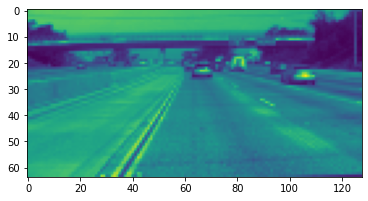

In [96]:
plt.imshow(image)

In [97]:
x = torch.FloatTensor(random_sample[0]).cuda()
x = x.unsqueeze(0)
out = model(x.to(DEVICE))

In [98]:
transformation_coeffcient = torch.cat(
    [out[0], torch.tensor([1.0], dtype=torch.float64).to(DEVICE)], -1
).type(torch.float64)
mult = (
    torch.tensor([1e-02, 1e-01, 1e-01, 1e-01, 1e-01, 1e-03, 1])
    .type(torch.float32)
    .to(DEVICE)
)
transformation_coeffcient = transformation_coeffcient * mult
print(transformation_coeffcient)
H_indices = torch.tensor(
    [[0], [1], [2], [4], [5], [7], [8]], requires_grad=False
).to(DEVICE)
R = torch.tensor(
    [-2.0484e-01, -1.7122e01, 3.7991e02, -1.6969e01, 3.7068e02, -4.6739e-02, 0.0000e00]
).to(DEVICE)
result = torch.zeros(9, dtype=torch.float64).to(DEVICE)
result[H_indices[:, 0]] = R + transformation_coeffcient
H = torch.reshape(result, shape=[3, 3])

tensor([-3.9205e-02,  1.5404e-01,  5.3141e-02,  3.3263e-01,  1.3465e-02,
        -4.8662e-04,  1.0000e+00], device='cuda:0', dtype=torch.float64,
       grad_fn=<MulBackward0>)


In [99]:
R = R.to(DEVICE)

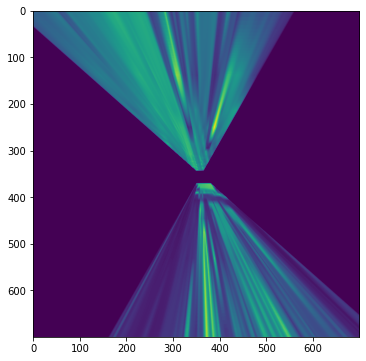

In [101]:
img = cv2.resize(image, HNET_DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.warpPerspective(img, H.detach().cpu().numpy(), dsize=(700, 700)))

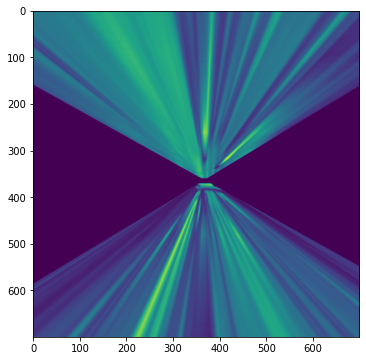

In [102]:
plt.figure(figsize=(6, 6))
plt.imshow(cv2.warpPerspective(img, R_np, dsize=(700, 700)))

# Part 3. Lane fitting

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [103]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.cluster import DBSCAN

DEFAULT_SIZE = (512, 256)
HNET_DEFAULT_SIZE = (128, 64)


class LaneDetector:
    def __init__(self, image, modelh, modelseg, degree=3):
        self.__image = image
        self.__degree = degree
        self.__modelh = modelh
        self.__modelseg = modelseg

    def __segment(self):
        threshold = 0.75
        img = cv2.resize(self.__image, DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        img = img.unsqueeze(0)
        segmentation, embeddings = self.__modelseg(img)

        binary_mask = torch.argmax(F.softmax(segmentation, dim=1), dim=1, keepdim=True)
        binary_mask = segmentation.data.cpu().numpy()
        binary_mask = binary_mask.squeeze()

        exp_mask = np.exp(binary_mask - np.max(binary_mask, axis=0))
        binary_mask = exp_mask / exp_mask.sum(axis=0)
        threshold_mask = binary_mask[1, :, :] > threshold
        threshold_mask = threshold_mask.astype(np.uint8)
        threshold_mask = threshold_mask  # *255

        kernel = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(1, 1))
        cv2.rectangle(threshold_mask, (0, 0), (512, 100), (0, 0, 0), thickness=-1)
        threshold_mask = cv2.dilate(threshold_mask, kernel, iterations=1)
        mask = cv2.connectedComponentsWithStats(
            threshold_mask, connectivity=4, ltype=cv2.CV_32S
        )
        output_mask = np.zeros(threshold_mask.shape, dtype=np.uint8)
        for label in np.unique(mask[1]):
            if label == 0:
                continue
            labelMask = np.zeros(threshold_mask.shape, dtype="uint8")
            labelMask[mask[1] == label] = 255
            numPixels = cv2.countNonZero(labelMask)
            if numPixels > 500:
                output_mask = cv2.add(output_mask, labelMask)
        output_mask = output_mask.astype(np.float) / 255

        self.__embedding = embeddings.squeeze().data.cpu().numpy()
        self.__binary = output_mask

        print("Segmentation output")
        plt.imshow(self.__binary)
        return output_mask, embeddings

    def __get_lane_area(self):
        idx = np.where(self.__binary.T == 1)
        lane_area = []
        lane_idx = []
        for i, j in zip(*idx):
            lane_area.append(self.__embedding[:, j, i])
            lane_idx.append((j, i))
        return np.array(lane_area), lane_idx

    def __cluster(self, prediction):
        clustering = DBSCAN(eps=0.5, min_samples=500).fit(prediction)

        return clustering.labels_

    def __get_instance_masks(self):
        gt_img = self.__image
        gt_img = cv2.resize(gt_img, HNET_DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
        gt_img = gt_img * (1.0 / gt_img.max())
        gt_img = np.rollaxis(gt_img, 2, 0)
        hnet_im = np.expand_dims(gt_img, 0)
        hnet_im = torch.FloatTensor(hnet_im)

        out = self.__modelh(hnet_im)
        transformation_coeffcient = torch.cat(
            [out[0], torch.tensor([1.0], dtype=torch.float32)], -1
        ).type(torch.float32)
        mult = torch.tensor([1e-02, 1e-01, 1e-01, 1e-01, 1e-01, 1e-03, 1]).type(
            torch.float32
        )
        transformation_coeffcient = transformation_coeffcient * mult
        H_indices = torch.tensor(
            [[0], [1], [2], [4], [5], [7], [8]], requires_grad=False
        )
        R = torch.tensor(
            [
                -2.0484e-01,
                -1.7122e01,
                3.7991e02,
                -1.6969e01,
                3.7068e02,
                -4.6739e-02,
                0.0000e00,
            ]
        )
        result = torch.zeros(9, dtype=torch.float32)
        result[H_indices[:, 0]] = R + transformation_coeffcient
        H = torch.reshape(result, shape=[3, 3])

        xx = self.__segment()
        lane_area, lane_idx = self.__get_lane_area()
        lane_idx = np.array(lane_idx)

        image = self.__image
        mask = np.zeros_like(image)
        segmentation_mask = np.zeros_like(image)
        if len(lane_area.shape) != 2:
            return image
        labels = self.__cluster(lane_area)

        _, unique_label = np.unique(labels, return_index=True)
        unique_label = labels[np.sort(unique_label)]
        color_map = {}
        polynomials = defaultdict(list)
        for index, label in enumerate(unique_label):
            color_map[label] = index
        for index, label in enumerate(labels):
            if len(polynomials[label]) == 0:
                polynomials[label].append([lane_idx[index][0], lane_idx[index][1], 1])
            elif 30 > lane_idx[index][1] - polynomials[label][-1][1] > 5:
                polynomials[label].append([lane_idx[index][0], lane_idx[index][1], 1])

        x_for_ypos = []
        for label in polynomials.keys():
            a = (
                np.array(polynomials[label])[:, 1] / 4,
                np.array(polynomials[label])[:, 0] / 4,
            )
            a = np.array(a, np.float32)
            a = torch.FloatTensor(a)
            line = torch.cat((a.T, torch.ones(a.size(1), 1)), 1)

            if line.shape[0] < 5:
                continue

            line_projected = torch.mm(H, line.T)
            line_projected = torch.div(line_projected, line_projected[2, :])

            X = line_projected[0, :].view(-1, 1)
            Y = line_projected[1, :].view(-1, 1)

            if self.__degree == 2:
                Y_mat = torch.cat(
                    [torch.pow(Y, 2), Y, torch.ones_like(Y, dtype=torch.float32)], dim=1
                )
            else:
                Y_mat = torch.cat(
                    [
                        torch.pow(Y, 3),
                        torch.pow(Y, 2),
                        Y,
                        torch.ones_like(Y, dtype=torch.float32),
                    ],
                    dim=1,
                )

            w = torch.matmul(
                torch.matmul(torch.pinverse(torch.matmul(Y_mat.T, Y_mat)), Y_mat.T), X
            )
            x_pred = torch.mm(Y_mat, w)

            line_pred = torch.cat(
                [x_pred, Y, torch.ones_like(Y, dtype=torch.float32)], dim=1
            ).t()
            line_back = torch.mm(H.pinverse(), line_pred)
            line_back = torch.div(line_back, line_back[2, :]).T
            line_back = line_back[line_back[:, 0] > 0]

            x_for_ypos.append(line_back.detach().cpu().numpy())

            if line_back.shape[0] < 10:
                continue

        lane_cnt = len(x_for_ypos)

        plt.figure(figsize=(10, 10))
        print("Final lane predicts after lane fitting")
        plt.imshow(self.__image)
        for i in range(lane_cnt):
            plt.scatter(
                x_for_ypos[i][:, 0] * 10,
                x_for_ypos[i][:, 1] * 11.25,
                marker="x",
                s=50,
                cmap="hsv",
            )
        plt.xlim([0, 1280])
        plt.ylim([720, 0])

        plt.show()

        return x_for_ypos

    def __call__(self):
        return self.__get_instance_masks()

In [104]:
import random

def fixed_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixed_seed(42)

In [105]:
def minmax_scale(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)

    output_arr = (arr - min_val) * 255.0 / (max_val - min_val)
    return output_arr

In [107]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_lnet = ENet()
model_lnet.load_state_dict(
    torch.load("/content/drive/MyDrive/CV_SGA/enet-0.01489347405731678-19.pkl")
)
model_lnet.eval()

model_hnet = HNet()
model_hnet.load_state_dict(
    torch.load("/content/drive/MyDrive/CV_SGA/hnet-0.25721-29.pkl")
)
model_hnet.eval();

In [118]:
image1 = cv2.imread("/data/tusimple/clips/0313-1/39120/1.jpg", cv2.IMREAD_COLOR)
image10 = cv2.imread("/data/tusimple/clips/0313-1/39120/10.jpg", cv2.IMREAD_COLOR)
image20 = cv2.imread("/data/tusimple/clips/0313-1/39120/20.jpg", cv2.IMREAD_COLOR)

Segmentation output
Final lane predicts after lane fitting


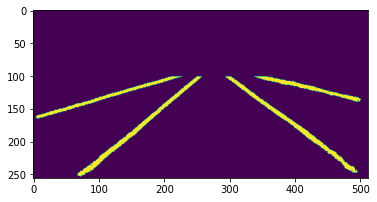

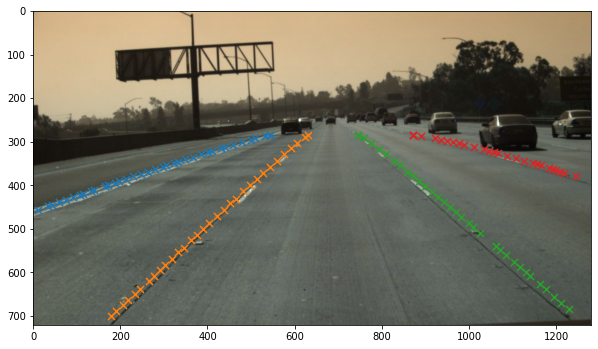

In [119]:
cluster = LaneDetector(image=image1, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

Segmentation output
Final lane predicts after lane fitting


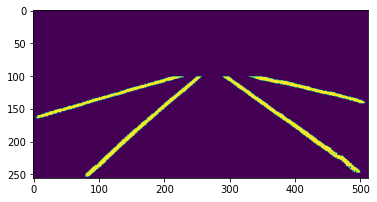

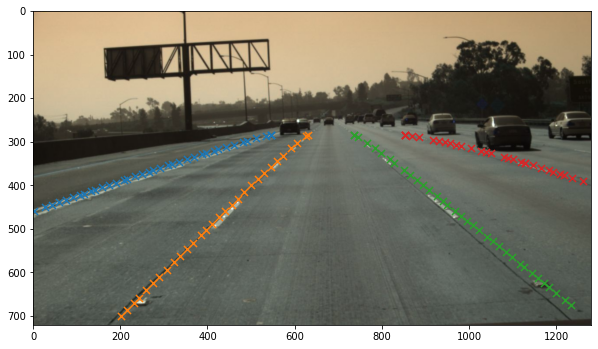

In [120]:
cluster = LaneDetector(image=image10, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

Segmentation output
Final lane predicts after lane fitting


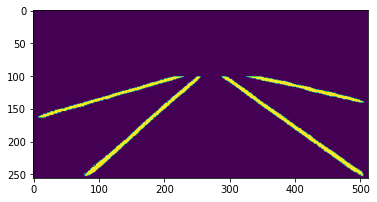

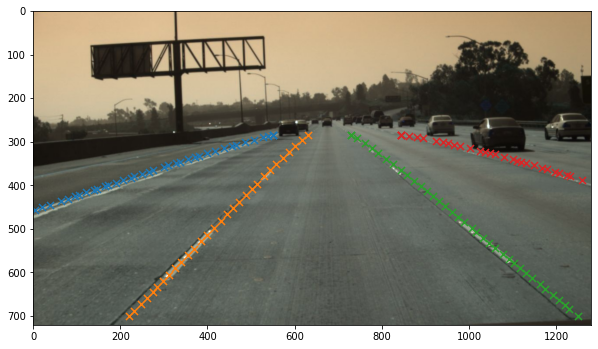

In [121]:
cluster = LaneDetector(image=image20, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

In [130]:
image_1 = cv2.imread("/data/tusimple/clips/0313-1/3540/1.jpg", cv2.IMREAD_COLOR)
image_10 = cv2.imread("/data/tusimple/clips/0313-1/3540/10.jpg", cv2.IMREAD_COLOR)
image_20 = cv2.imread("/data/tusimple/clips/0313-1/3540/20.jpg", cv2.IMREAD_COLOR)

Segmentation output
Final lane predicts after lane fitting


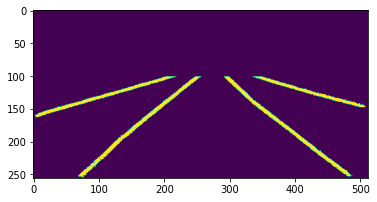

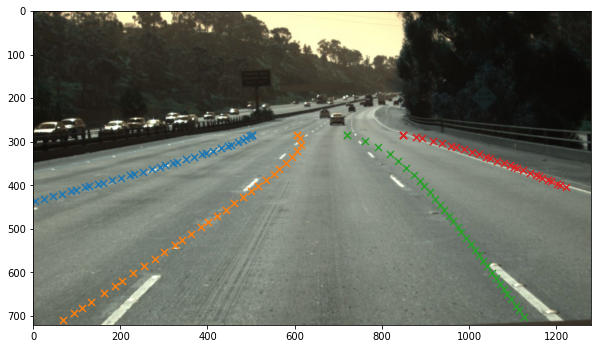

In [131]:
cluster = LaneDetector(image=image_1, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

Segmentation output
Final lane predicts after lane fitting


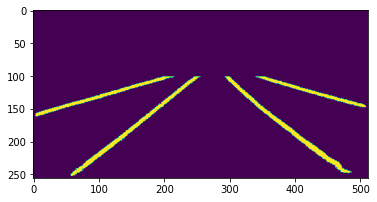

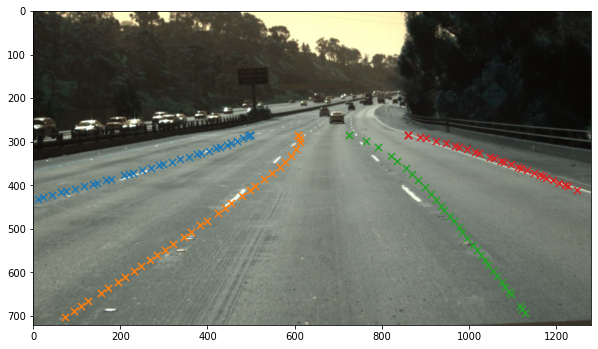

In [132]:
cluster = LaneDetector(image=image_10, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

Segmentation output
Final lane predicts after lane fitting


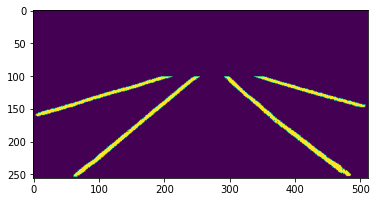

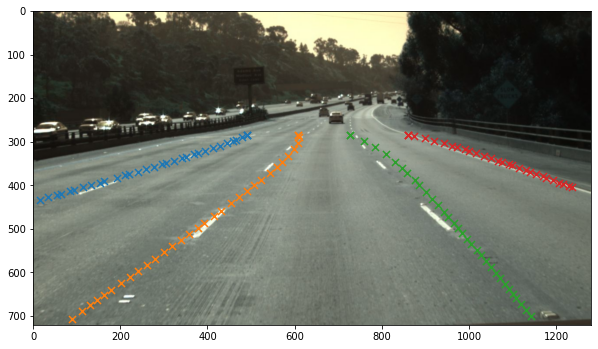

In [133]:
cluster = LaneDetector(image=image_20, degree=2, modelh=model_hnet, modelseg=model_lnet)
x_preds = cluster()

---

*Prepared by Sergey Afanasiev*